In [1]:
import os
import io
import time
import japanize_matplotlib
import pathlib
import yaml

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt 

from yaml import Loader

# Creates a dataframe with gps and event data.
class MatchData():
    def __init__(self, match_name):
        self.match_name = match_name
        self.gps_path = 'data/{0}/gps'.format(match_name)
        self.event_path = 'data/{0}/splyza'.format(match_name)
        self.init_yaml()
        self.outpath = 'myTheme/static/graphs/'+match_name+'/'
        pathlib.Path(self.outpath).mkdir(parents=True, exist_ok=True) 
        
        self.gps_data = self.get_gps_data()
        self.event_data = self.get_event_data()
        self.data = self.generate_data()
        
    def init_yaml(self):
        f = open("content/"+self.match_name+'.md',"r")
        text = f.read().split('---')[0]
        self.yaml = yaml.load(text, Loader=Loader)
        
        
    def get_gps_data(self): 
        path = self.gps_path
        start = dt.time.min
        end = dt.time.max
        d = {}
        
        for f in os.listdir(path):
            if f.endswith('.csv'):

                # 個人のメタデータの取得
                _ = pd.read_csv(open('{0}/{1}'.format(path, f),'rU'), encoding='utf-8', engine='c', nrows=5, header=None, index_col=0).T
                player_name = _['Player'].iloc[0][2:]
                session = _['Session'].iloc[0][2:]
                _start = dt.time(*time.strptime(_['Start'].iloc[0], "%M:%S.%f")[3:6])
                _end = dt.time(*time.strptime(_['End'].iloc[0], '%M:%S.%f')[3:6])

                # start=最小の_start, end=最大の_end
                start = max(start, _start)
                end = max(end, _end)

                # 個人のGPSデータの取得
                _df = pd.read_csv('{0}/{1}'.format(path, f), skiprows=7, 
                                  usecols=[
                                      'Time',
                                      'Speed (km/h)',
                                      'X (m)',
                                      'Y (m)',
                                      'Acceleration (m/s/s)'
                                  ])
                d[player_name] = _df
        self.start = start
        self.end = end
        return d
    
    def get_event_data(self):
        path = self.event_path
        flist = os.listdir(path)
        data = [pd.read_csv('{0}/{1}'.format(path, f), index_col=0) for f in os.listdir(path)]
        
        for i, d in enumerate(data):                
            data[i].index = data[i].index.map(lambda x: dt.time(*time.strptime(x[4:12], '%M:%S:%f')[3:6]))
            
        d = {'h1':data[0],'h2':data[1]}
        return d
    
    def generate_data(self):
        gps_data = self.gps_data
        event_data = self.event_data
        return gps_data, event_data
    
    def get_count(self, attr):
        try:
            d = pd.concat((self.event_data['h1'],self.event_data['h2']), sort=False)
            value = d.apply(pd.value_counts,axis=0).apply(lambda x: x.max(), axis=1)[attr]
        except:
            value = 0
        return value
    
    def stats_hbar(self, meta=None, show=False):
        '''
        Sample data to give to this is:
        meta = {
            'def':{
                'events' : ['シュートブロック', 'クリア', 'インターセプト', 'ブロック'],
                '回数'   : [79, 60, 45,85],
            }
        }
        '''
        # data generating function
        def f(l):
            counts = [int(self.get_count(attr)) for attr in l]
            dic = {
                'events':l,
                '_':[max(counts)]*len(counts),
                '回数':counts,
            }
            return dic
        if meta==None:
            meta = {
                'atk':f(['パス', '枠内シュート', 'ドリブル', 'クロス', '枠外シュート']),
                'def':f(['シュートブロック', 'クリア', 'インターセプト', 'ブロック']),
                'set':f(['スローイン', 'CK', 'FK', 'PK']),
                'foul':f(['ファール', 'オフサイド']),
            }
                    
        text_left = 0 # Used for formatting text
        color = ["dark", "muted", "pastel"]
        for chart_name, chart_data in meta.items():
            f, ax = plt.subplots(figsize=(6, 10))

            i=0
            for attr_name, attr_data in chart_data.items():
                if attr_name == 'events':
                    continue
                else:
                    sns.set_color_codes(color[i])
                    sns.barplot(x=attr_name, y="events", data=chart_data, label=attr_name, color="b")
                    text_left = max(text_left, max(attr_data))
                    i+=1
                    
            i=0
            text_left = text_left/20
            for event, kaisu in zip(chart_data['events'],chart_data['回数']):
                ax.text(text_left,i-0.15, event, fontsize=35, color='white')
                ax.text(text_left,i+0.15, '{0}'.format(kaisu), fontsize=35, color='red')
                i+=1
            
            # Add a legend and informative axis label
            ax.legend(ncol=2, loc="lower right", frameon=True)
            plt.axis('off')
            plt.title(chart_name, fontsize=40)
            sns.despine(left=True, bottom=True)
            if show!=True:
                plt.savefig("{0}hbar_{1}.png".format(self.outpath, chart_name), transparent=True,bbox_inches='tight')
                plt.cla()
            else:
                plt.show() 

    def rank_table(self, show=False):
        h1 = match_data.event_data['h1'].reset_index()
        h2 = match_data.event_data['h2'].reset_index()
        d = pd.concat([h1,h2],sort=False)
        cdict = {
            '攻撃':'crimson',
            '守備':'#40466e',
        }
        for e in ['攻撃', '守備']:
            df = pd.DataFrame(d.groupby('選手名')[e].value_counts())
            df.columns=['count']
            df = df.swaplevel(1, 0, axis=0)
            df = df.reset_index()
            groups = df.groupby(e)
            for name, group in groups:
                group = group.sort_values('count', ascending=False)
                render_mpl_table(group[['選手名','count']], header_color=cdict[e])
                plt.title(name)
                if show!=True:
                    plt.savefig("{0}/{1}.png".format(self.outpath, name), transparent=True,bbox_inches='tight')
                    plt.cla()
                else:
                    plt.show() 
                    
    def plot_pitch(height=68, width=105, xos=0, yofs=0):
        hscaler = 68 / height
        wscaler = 105 / width
        # Create figure
        fig = plt.figure(facecolor='green',figsize=(21, 15))
        ax = fig.add_subplot(1, 1, 1)

        ax.set_xlim([0,width])
        ax.set_ylim([0,height])

        color1 = 'white'
        center = (xos + width / 2, yofs + height / 2)

        # Pitch Outline & Centre Line
        plt.plot([xos, xos], [yofs, yofs + height], color=color1)
        plt.plot([xos, xos + width], [yofs + height, yofs + height], color=color1)
        plt.plot([xos + width, xos + width], [yofs + height, yofs], color=color1)
        plt.plot([xos + width, xos], [yofs, yofs], color=color1)
        plt.plot([xos + width / 2, xos + width / 2], [yofs, yofs + height], color=color1)

        # Left Penalty Area
        plt.plot([xos + 16.5 / wscaler, xos + 16.5 / wscaler],
                 [yofs + height / 2 + 20.15 / hscaler, yofs + height / 2 - 20.15 / hscaler], color=color1)
        plt.plot([xos, xos + 16.5 / wscaler], [yofs + height / 2 + 20.15 / hscaler, yofs + height / 2 + 20.15 / hscaler],
                 color=color1)
        plt.plot([xos + 16.5 / wscaler, xos], [yofs + height / 2 - 20.15 / hscaler, yofs + height / 2 - 20.15 / hscaler],
                 color=color1)

        # Right Penalty Area
        plt.plot([xos + width - 16.5 / wscaler, xos + width - 16.5 / wscaler],
                 [yofs + height / 2 + 20.15 / hscaler, yofs + height / 2 - 20.15 / hscaler], color=color1)
        plt.plot([xos + width, xos + width - 16.5 / wscaler],
                 [yofs + height / 2 + 20.15 / hscaler, yofs + height / 2 + 20.15 / hscaler], color=color1)
        plt.plot([xos + width - 16.5 / wscaler, xos + width],
                 [yofs + height / 2 - 20.15 / hscaler, yofs + height / 2 - 20.15 / hscaler], color=color1)

        # Left 6-yard Box
        plt.plot([xos + 5.5 / wscaler, xos + 5.5 / wscaler],
                 [yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler],
                 color=color1)
        plt.plot([xos, xos + 5.5 / wscaler],
                 [yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler],
                 color=color1)
        plt.plot([xos + 5.5 / wscaler, xos],
                 [yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler],
                 color=color1)

        # Right 6-yard Box
        plt.plot([xos + width - 5.5 / wscaler, xos + width - 5.5 / wscaler],
                 [yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler],
                 color=color1)
        plt.plot([xos + width, xos + width - 5.5 / wscaler],
                 [yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 + (7.32 / 2 + 5.5) / hscaler],
                 color=color1)
        plt.plot([xos + width - 5.5 / wscaler, xos + width],
                 [yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler, yofs + height / 2 - (7.32 / 2 + 5.5) / hscaler],
                 color=color1)

        #     # Prepare Circles
        centre_circle = plt.Circle(center, 9.15 / hscaler, color=color1, fill=False)
        centre_cspot = plt.Circle(center, 0.8 / hscaler, color=color1)
        left_pen_spot = plt.Circle((xos + 11 / wscaler, yofs + height / 2), 0.8 / hscaler, color=color1)
        right_pen_spot = plt.Circle((xos + width - 11 / wscaler, yofs + height / 2), 0.8 / hscaler, color=color1)

        #     # Draw Circles
        ax.add_patch(centre_circle)
        ax.add_patch(centre_cspot)
        ax.add_patch(left_pen_spot)
        ax.add_patch(right_pen_spot)

        #     # Prepare Arcs
        leftArc = Arc((xos + 11 / wscaler, yofs + height / 2), height=18.3 / hscaler, width=18.3 / wscaler, angle=0,
                      theta1=310, theta2=50, color=color1)
        rightArc = Arc((xos + width - 11 / wscaler, yofs + height / 2), height=18.3 / hscaler, width=18.3 / wscaler,
                       angle=0, theta1=130, theta2=230, color=color1)

        #     # Draw Arcs
        ax.add_patch(leftArc)
        ax.add_patch(rightArc)

        # Tidy Axes
        plt.axis('off')
        plt.xlim(0, width)
        plt.ylim(0, height)
        plt.autoscale(False)
        plt.axis('equal')

        # Display Pitch
        return fig, ax
    def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                         header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                         bbox=[0, 0, 1, 1], header_columns=0,
                         ax=None, **kwargs):
        if ax is None:
            size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
            fig, ax = plt.subplots(figsize=size)
            ax.axis('off')

        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(font_size)

        for k, cell in  mpl_table._cells.items():
            cell.set_edgecolor(edge_color)
            if k[0] == 0 or k[1] < header_columns:
                cell.set_text_props(weight='bold', color='w')
                cell.set_facecolor(header_color)
            else:
                cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
        return ax

    def average_positions(self):
        d = match_data.get_gps_data()
        dic = {}
        for player, df in d.items():
            dic[player] = (df['X (m)'].mean(), df['Y (m)'].mean())
        return dic

In [5]:
match_data = MatchData('4sec_vsMeiji')


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 'U' mode is deprecated


In [19]:
from matplotlib.patches import Arc
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

    return artists


fig, ax = plot_pitch()
for player, data in match_data.average_positions().items():
    x = player, data 
    y = 
x = 12.5
y = 34
x2 = 48
y2 = 20
imscatter(x, y, 'myTheme/static/images/profile_imgs/mitomakaoru-removebg.png',ax, 0.3)

textstr = '\n'.join((
    '%s'% ('三笘薫'),
    '走行距離：%.1fKM' % (10, ),
    'Player Load：%.1f' % (20, ),
    'スプリント回数：%.d' % (40, )))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

ax.text(x+5, y+5, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

imscatter(x2, y2, 'myTheme/static/images/profile_imgs/mitomakaoru-removebg.png',ax, 0.3)

textstr = '\n'.join((
    '%s'% ('三笘薫'),
    '走行距離：%.1fKM' % (10, ),
    'Player Load：%.1f' % (20, ),
    'スプリント回数：%.d' % (40, )))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

ax.text(x2+5, y2+5, textstr, fontsize=14,
        verticalalignment='top', bbox=props)


ax.arrow(x, y, (x2-x)/1.2, (y2-y)/1.2, linewidth=3, head_width=1, head_length=1, fc='blue', ec='blue')
ax.arrow(x2-1, y2-1, (x-x2)/1.2, (y-y2)/1.2, linewidth=6, head_width=1, head_length=1, fc='red', ec='red')

data= [
    [ ('高嶺',66), ('三笘',17),  ('加藤',75), ('阿部',57),  ('永満',32)],
    [ ('高嶺',58), ('三笘',38),  ('山川',78),  ('阿部',99), ('永満',16)],
    [ ('高嶺',89),  ('三笘',80), ('山川',15), ('阿部',49), ('永満',60)],
    [ ('高嶺',78),  ('三笘',81), ('山川',15), ('大川',19),  ('永満',69)],
    [('高嶺',13), ('山川',33), ('加藤',34), ('大川',78),  ('永満',52)]
]

cell_text = []
columns = ['走行距離', 'HI距離','最高速度','最高速度','スプリント回数']
for index, row in enumerate(data):
    row.sort(key=lambda tup: tup[1], reverse=True)
    cell_text.append(['{0} {1}'.format(name, num) for (name, num) in row])

cell_text = list(map(list, zip(*cell_text)))
the_table = plt.table(cellText=cell_text, colLabels=columns,
                     loc='bottom')


plt.tight_layout()
# plt.savefig(path+'pitch.png', facecolor='green', bbox_inches='tight')
plt.show()

SyntaxError: invalid syntax (<ipython-input-19-f375d192aa41>, line 27)

In [1]:
yam = match_data.yaml

NameError: name 'match_data' is not defined

In [21]:
import math
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def ang(v1, v2):
    return math.acos(dotproduct(v1, v2) / (length(v1) * length(v2)))


scale = 105 / np.linalg.norm(f(yam['p1'])-f(yam['p3'])) 
angle = ang(f(yam['p1'])-f(yam['p3']), np.asarray([0, 105]))

trans_mat = np.asarray([
    [1, 0, -f(yam['p1'])[0]],
    [0, 1, -f(yam['p1'])[1]],
    [0,0,1]
])

scale_mat = np.asarray([
    [scale, 0, 0],
    [0, scale, 0],
    [0,0,1]
])

rot_mat = np.asarray([
    [np.cos(angle),-np.sin(angle), 0],
    [np.sin(angle), np.cos(angle), 0],
    [0,0,1]
])

NameError: name 'f' is not defined

In [22]:
a = trans_mat @ np.append(f(yam['p3']),[1])
b = scale_mat @ a
c = rot_mat @ b
c

NameError: name 'trans_mat' is not defined

In [23]:
scale * np.linalg.norm(f(yam['p1'])-f(yam['p2'])) 

NameError: name 'scale' is not defined

In [24]:
M = cv2.getAffineTransform([(0,0), (58,0), (58,105)], [f(yam['p1']),f(yam['p2']),f(yam['p3'])])

NameError: name 'cv2' is not defined

In [25]:
def f(x):
    x = x.split(',')
    return np.asarray(x, dtype=np.float64())

def solve_affine( p1, p2, p3, s1, s2, s3):
    x = np.transpose(np.matrix([p1,p2,p3]))
    y = np.transpose(np.matrix([s1,s2,s3]))
    # add ones on the bottom of x and y
    x = np.vstack((x,[1,1,1]))
    y = np.vstack((y,[1,1,1]))
    # solve for A2
    A2 = y * x.I
    # return function that takes input x and transforms it
    # don't need to return the 4th row as it is 
    return A2

def pitch_co(x, y):
    def solve_affine( p1, p2, p3, s1, s2, s3):
        x = np.transpose(np.matrix([p1,p2,p3]))
        y = np.transpose(np.matrix([s1,s2,s3]))
        # add ones on the bottom of x and y
        x = np.vstack((x,[1,1,1]))
        y = np.vstack((y,[1,1,1]))
        # solve for A2
        A2 = y * x.I
        # return function that takes input x and transforms it
        # don't need to return the 4th row as it is 
        return A2

    M = solve_affine(f(yam['p1']),f(yam['p2']),f(yam['p3']),
                 (0,0,1), (58,0,1), (0,105,1))
    return (M @ np.asarray([x,y,1]))[0,:2]

pitch_co(*f(yam['p1']))

matrix([[ 9.31322575e-10, -1.86264515e-09]])

/home/atom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DeprecationWarning: 'U' mode is deprecated


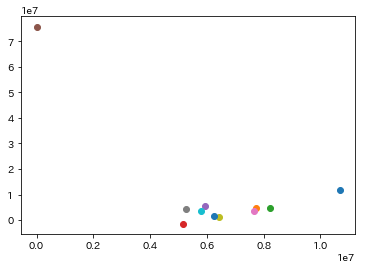

In [31]:
for name, player in match_data.average_positions().items():
    x = pitch_co(*player)[0,0]
    y = pitch_co(*player)[0,1]
    
#     plot_pitch()
    if x > 0 :
        plt.scatter(x,y)

#     print(x,y)
#     print(name, pitch_co(*player))

In [32]:
x

6250468.026396591